# SIF Analysis: Tariffs & Crop Shifts in the Corn Belt

This notebook analyzes Solar-Induced Chlorophyll Fluorescence (SIF) data from OCO-2/OCO-3 satellites to investigate how U.S. trade tariffs, input costs, and management changes since 2020 have influenced vegetation productivity across the U.S. Corn Belt.

**Dataset**: Harmonized, gap-filled global SIF product (2014-2024) by Jiaming Wen et al.

**Goals**:
- Visualize SIF changes over time (2014-2024) 
- Create US-focused animation showing temporal patterns
- Later: Overlay with USDA Cropland Data Layer for crop-specific analysis


In [23]:
# Test paths and verify we can find the data
from pathlib import Path
import os

print("Current working directory:", os.getcwd())
print()

# Test the data directory path
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
print(f"Looking for data in: {data_dir}")
print(f"Data directory exists: {data_dir.exists()}")
print(f"Absolute path: {data_dir.absolute()}")

if data_dir.exists():
    nc4_files = list(data_dir.glob("*.nc4"))
    print(f"Found {len(nc4_files)} .nc4 files")
    if nc4_files:
        print(f"First file: {nc4_files[0].name}")
        print("✓ Data directory and files found!")
    else:
        print("⚠ Data directory exists but no .nc4 files found")
else:
    print("❌ Data directory not found - check the path")

print()
print("If this works, you can proceed to run the other cells in order.")


Current working directory: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src

Looking for data in: ../data/raw/SIF_OCO2_005_v11r
Data directory exists: True
Absolute path: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src/../data/raw/SIF_OCO2_005_v11r
Found 251 .nc4 files
First file: sif_ann_201503a.nc4
✓ Data directory and files found!

If this works, you can proceed to run the other cells in order.


## 1. Setup and Data Discovery


In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import imageio
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

ds = xr.open_dataset("../data/raw/SIF_OCO2_005_v11r/sif_ann_201409a.nc4")
print(ds.dims)
print(ds.coords)


FrozenMappingWarningOnValuesAccess({'latitude': 3600, 'longitude': 7200})
Coordinates:
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * latitude   (latitude) float64 29kB -89.97 -89.92 -89.88 ... 89.92 89.97


In [25]:
# Define paths
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
figures_dir = Path("../figures")

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Figures directory: {figures_dir}")


Data directory: ../data/raw/SIF_OCO2_005_v11r
Figures directory: ../figures


In [26]:
# List all .nc4 files and extract temporal information
nc4_files = sorted(data_dir.glob("*.nc4"))
print(f"Found {len(nc4_files)} .nc4 files")

# Extract detailed information from filenames
# Format: sif_ann_yyyymm"a"or"b".nc4 (e.g., sif_ann_201401a.nc4, sif_ann_201401b.nc4)

file_info = []
for file in nc4_files:
    filename = file.name
    if 'sif_ann_' in filename:
        # Extract the part after 'sif_ann_' and before '.nc4'
        year_month_part = filename.split('sif_ann_')[1].split('.nc4')[0]
        
        if year_month_part.endswith('a') or year_month_part.endswith('b'):
            # Extract all components
            half = year_month_part[-1]  # 'a' = first half, 'b' = second half of month
            year_month = year_month_part[:-1]  # Remove 'a' or 'b'
            year = year_month[:4]  # Extract year (e.g., '2014')
            month = year_month[4:]  # Extract month (e.g., '01')
            
            # Store detailed info
            file_info.append({
                'filename': filename,
                'year': year,
                'month': month,
                'half': half,
                'half_description': 'first half' if half == 'a' else 'second half',
                'year_month': year_month,
                'file_path': file,
                'sort_key': f"{year}{month}{half}"  # For proper chronological sorting
            })

# Sort by chronological order
file_info = sorted(file_info, key=lambda x: x['sort_key'])

# Create summary
years = sorted(list(set([info['year'] for info in file_info])))
months = sorted(list(set([info['month'] for info in file_info])))

print(f"\n📊 Dataset Summary:")
print(f"  Total files: {len(file_info)}")
print(f"  Years: {years} ({len(years)} years)")
print(f"  Months: {months} ({len(months)} months)")
print(f"  Year range: {min(years)} - {max(years)}")

# Show first few files in chronological order
print(f"\n📁 First 5 files (chronological order):")
for i, info in enumerate(file_info[:5]):
    print(f"  {info['filename']} → {info['year']}-{info['month']} ({info['half_description']})")


Found 251 .nc4 files

📊 Dataset Summary:
  Total files: 251
  Years: ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025'] (12 years)
  Months: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] (12 months)
  Year range: 2014 - 2025

📁 First 5 files (chronological order):
  sif_ann_201409a.nc4 → 2014-09 (first half)
  sif_ann_201409b.nc4 → 2014-09 (second half)
  sif_ann_201410a.nc4 → 2014-10 (first half)
  sif_ann_201410b.nc4 → 2014-10 (second half)
  sif_ann_201411a.nc4 → 2014-11 (first half)


## 2. Create US-Focused Animation


In [6]:
# Define US bounding box for focused visualization
us_bounds = {
    'lon_min': -125.0,  # West Coast
    'lon_max': -66.0,   # East Coast  
    'lat_min': 24.0,    # Southern border
    'lat_max': 49.0     # Northern border
}

print("US bounding box:")
print(f"Longitude: {us_bounds['lon_min']} to {us_bounds['lon_max']}")
print(f"Latitude: {us_bounds['lat_min']} to {us_bounds['lat_max']}")

# Set up fixed color scale for consistent comparison across time
vmin, vmax = 0.0, 2.0  # mW/m²/nm/sr
cmap = 'viridis'

print(f"\nColor scale: {vmin} - {vmax} mW/m²/nm/sr")
print(f"Colormap: {cmap}")


US bounding box:
Longitude: -125.0 to -66.0
Latitude: 24.0 to 49.0

Color scale: 0.0 - 2.0 mW/m²/nm/sr
Colormap: viridis


In [ ]:
# Function to load and process SIF data
def load_sif_data(file_path, fill_value=-9999):
    """Load SIF data and mask fill values"""
    ds = xr.open_dataset(file_path)
    sif = ds['sif_ann']
    
    # Mask fill values
    sif_masked = sif.where(sif != fill_value)
    
    return sif_masked

# Create animation frames for US region
print("Creating animation frames for US region...")
frames = []

for i, info in enumerate(file_info):
    print(f"Processing frame {i+1}/{len(file_info)}: {info['filename']}")
    
    # Load SIF data
    sif_data = load_sif_data(info['file_path'])
    
    # Extract US region
    sif_us = sif_data.sel(
        longitude=slice(us_bounds['lon_min'], us_bounds['lon_max']),
        latitude=slice(us_bounds['lat_min'], us_bounds['lat_max'])
    )
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot SIF data
    im = sif_us.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True)
    
    # Customize plot
    ax.set_title(f'SIF - {info["year"]}-{info["month"]} ({info["half_description"]})', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add text annotation with frame info
    ax.text(0.02, 0.98, f'Frame {i+1}/{len(file_info)}', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save frame
    frame_path = figures_dir / f'frame_{i+1:03d}.png'
    plt.savefig(frame_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    # Add to frames list
    frames.append(str(frame_path))

print(f"\nCreated {len(frames)} frames")


Creating animation frames for US region...
Processing frame 1/251: sif_ann_201409a.nc4
Processing frame 2/251: sif_ann_201409b.nc4
Processing frame 3/251: sif_ann_201410a.nc4
Processing frame 4/251: sif_ann_201410b.nc4
Processing frame 5/251: sif_ann_201411a.nc4
Processing frame 6/251: sif_ann_201411b.nc4
Processing frame 7/251: sif_ann_201412a.nc4
Processing frame 8/251: sif_ann_201412b.nc4
Processing frame 9/251: sif_ann_201501a.nc4
Processing frame 10/251: sif_ann_201501b.nc4
Processing frame 11/251: sif_ann_201502a.nc4
Processing frame 12/251: sif_ann_201502b.nc4
Processing frame 13/251: sif_ann_201503a.nc4
Processing frame 14/251: sif_ann_201503b.nc4
Processing frame 15/251: sif_ann_201504a.nc4
Processing frame 16/251: sif_ann_201504b.nc4
Processing frame 17/251: sif_ann_201505a.nc4
Processing frame 18/251: sif_ann_201505b.nc4
Processing frame 19/251: sif_ann_201506a.nc4
Processing frame 20/251: sif_ann_201506b.nc4
Processing frame 21/251: sif_ann_201507a.nc4
Processing frame 22/2

In [ ]:
# Create GIF animation
print("Creating GIF animation...")
gif_path = figures_dir / 'sif_us_animation_2014_2024.gif'

# Read images and create GIF
images = []
for frame_path in frames:
    images.append(imageio.imread(frame_path))

# Create GIF with 0.5 seconds per frame (faster animation)
imageio.mimsave(gif_path, images, duration=0.5)

print(f"✅ GIF animation saved to: {gif_path}")
print(f"Animation shows SIF changes from {file_info[0]['year']}-{file_info[0]['month']} to {file_info[-1]['year']}-{file_info[-1]['month']}")
print(f"Total frames: {len(frames)}")

# Clean up individual frame files (optional)
print("\nCleaning up individual frame files...")
for frame_path in frames:
    Path(frame_path).unlink()
print("✅ Frame cleanup complete")

print(f"\n🎬 Your US SIF animation is ready!")
print(f"📁 Location: {gif_path}")
print(f"📊 Shows: {len(file_info)} time points from {min(years)} to {max(years)}")
print(f"🗺️  Region: Continental United States")
print(f"📈 Color scale: {vmin} - {vmax} mW/m²/nm/sr")


Creating GIF animation...
✅ GIF animation saved to: ../figures/sif_us_animation_2014_2024.gif
Animation shows SIF changes from 2014-09 to 2025-04
Total frames: 251

Cleaning up individual frame files...
✅ Frame cleanup complete

🎬 Your US SIF animation is ready!
📁 Location: ../figures/sif_us_animation_2014_2024.gif
📊 Shows: 251 time points from 2014 to 2025
🗺️  Region: Continental United States
📈 Color scale: 0.0 - 2.0 mW/m²/nm/sr


## 3. Monthly Averages
Take monthly averages only in Iowa of SIF. Calculate morning (a) and evening (b). As well as the combined avergae.

In [13]:
# Load libraries
from pathlib import Path
import re, numpy as np, pandas as pd, xarray as xr

# Create path to SIF data
SIF_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/SIF_OCO2_005_v11r")

# Clip by a simple Iowa bounding box (EPSG:4326) to speed things up
USE_BBOX = True  # set False if you prefer loading a shapefile/poly later
IOWA_BBOX = (-96.639, -90.140, 40.375, 43.501)  # lon_min, lon_max, lat_min, lat_max

# Where to save quick CSV outputs 
OUT_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [15]:
# --- Mask out non-Ag areas with CDL -------------------
# Load CDL rasters for 2014-2024 and check CRS compatibility
import rasterio

# Define CDL directory
CDL_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/Cornbelt_annual_CDL")

# Find all CDL files
CDL_FILES = list(CDL_DIR.glob("*.tif"))
print(f"Found {len(CDL_FILES)} CDL files")

# Filter for years 2014-2024 and create a dictionary
cdl_files_by_year = {}
for file in CDL_FILES:
    # Extract year from filename (e.g., "Cornbelt_annual_CDL_cropland_2010-01.tif" -> "2010")
    year = int(file.stem.split('_')[-1].split('-')[0])
    if 2014 <= year <= 2024:
        cdl_files_by_year[year] = file
        print(f"  - {file.name} (Year: {year})")

print(f"\nCDL files for 2014-2024: {len(cdl_files_by_year)} files")
print(f"Years available: {sorted(cdl_files_by_year.keys())}")

# Check CDL file properties
print(f"\nChecking CDL file properties...")

# Load a sample CDL file to check its properties
sample_cdl_file = list(cdl_files_by_year.values())[0]
print(f"Sample CDL file: {sample_cdl_file.name}")

with rasterio.open(sample_cdl_file) as cdl_ds:
    cdl_crs = cdl_ds.crs
    print(f"CDL CRS: {cdl_crs}")
    
    # Show other properties
    print(f"CDL shape: {cdl_ds.shape}")
    print(f"CDL bounds: {cdl_ds.bounds}")
    print(f"CDL bands: {cdl_ds.count}")
    print(f"Band names: {cdl_ds.descriptions}")

print("✓ CDL loading complete!")
print("Note: CRS compatibility with SIF data will be checked later when file_info is available.")


Found 15 CDL files
  - Cornbelt_annual_CDL_cropland_2022-01.tif (Year: 2022)
  - Cornbelt_annual_CDL_cropland_2018-01.tif (Year: 2018)
  - Cornbelt_annual_CDL_cropland_2014-01.tif (Year: 2014)
  - Cornbelt_annual_CDL_cropland_2020-01.tif (Year: 2020)
  - Cornbelt_annual_CDL_cropland_2016-01.tif (Year: 2016)
  - Cornbelt_annual_CDL_cropland_2024-01.tif (Year: 2024)
  - Cornbelt_annual_CDL_cropland_2019-01.tif (Year: 2019)
  - Cornbelt_annual_CDL_cropland_2015-01.tif (Year: 2015)
  - Cornbelt_annual_CDL_cropland_2023-01.tif (Year: 2023)
  - Cornbelt_annual_CDL_cropland_2017-01.tif (Year: 2017)
  - Cornbelt_annual_CDL_cropland_2021-01.tif (Year: 2021)

CDL files for 2014-2024: 11 files
Years available: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Checking CDL file properties...
Sample CDL file: Cornbelt_annual_CDL_cropland_2022-01.tif
CDL CRS: EPSG:4326
CDL shape: (697, 1448)
CDL bounds: BoundingBox(left=-96.64075826557813, bottom=40.3747804447519, right=-90.1369556

In [48]:
# Resize agricultural masks to match SIF data resolution
print("=" * 60)
print("RESIZING AGRICULTURAL MASKS TO MATCH SIF DATA")
print("=" * 60)

# We need to get the target shape from SIF data first
if len(file_info) > 0:
    # Get target shape from first SIF file
    sample_info = file_info[0]
    da = open_sif_da(sample_info['file_path'])
    da_ia = clip_to_bbox_latlon(da, IOWA_BBOX)
    target_shape = da_ia.shape
    print(f"Target SIF data shape: {target_shape}")
    
    # Create resized masks dictionary
    resized_ag_masks = {}
    
    for year in sorted(ag_masks.keys()):
        if ag_masks[year] is not None:
            print(f"\nResizing mask for year {year}:")
            print(f"  Original shape: {ag_masks[year].shape}")
            
            # Resize the mask
            resized_mask = resize_mask_to_match_data(ag_masks[year], target_shape)
            resized_ag_masks[year] = resized_mask
            
            print(f"  Resized shape: {resized_mask.shape}")
            print(f"  Agricultural pixels: {np.sum(resized_mask)} / {resized_mask.size} ({100*np.sum(resized_mask)/resized_mask.size:.1f}%)")
        else:
            print(f"  Year {year}: No mask available")
    
    print(f"\n✓ Created resized masks for {len(resized_ag_masks)} years")
    print(f"All masks now have shape: {target_shape}")
    
    # Test one resized mask
    if 2014 in resized_ag_masks:
        print(f"\nTesting resized mask for 2014:")
        mu, sd = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, resized_ag_masks[2014])
        print(f"  Result with resized mask: mean={mu:.4f}, sd={sd:.4f}")
        
        # Compare with no mask
        mu_no_mask, sd_no_mask = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, None)
        print(f"  Result without mask:      mean={mu_no_mask:.4f}, sd={sd_no_mask:.4f}")
        print(f"  Difference:               mean={mu-mu_no_mask:.4f}, sd={sd-sd_no_mask:.4f}")
        
        if abs(mu - mu_no_mask) > 0.001:
            print("  ✓ Masking is working - values are different!")
        else:
            print("  ⚠️  Masking might not be working - values are very similar")
    
else:
    print("No file_info available")


RESIZING AGRICULTURAL MASKS TO MATCH SIF DATA
Target SIF data shape: (62, 130)

Resizing mask for year 2014:
  Original shape: (696, 1447)
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 547320
    Resized agricultural pixels: 4319
  Resized shape: (62, 130)
  Agricultural pixels: 4319 / 8060 (53.6%)

Resizing mask for year 2015:
  Original shape: (696, 1447)
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 530276
    Resized agricultural pixels: 4155
  Resized shape: (62, 130)
  Agricultural pixels: 4155 / 8060 (51.6%)

Resizing mask for year 2016:
  Original shape: (696, 1447)
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 530559
    Resized agricultural pixels: 4156
  Resized shape: (62, 130)
  Agricultural pixels: 4156 / 8060 (51.6%)

Resizing mask for year 2017:
  Original shape: (696, 1447)
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 541039
    R

In [42]:
# Clip CDL to Iowa bounding box and identify agricultural pixels
import rasterio.windows
import numpy as np

print("Creating agricultural masks for each year...")

# Function to create agricultural mask for a specific year
def create_ag_mask_for_year(year, iowa_bbox):
    """
    Create agricultural mask for a specific year using the cropland band.
    Returns True for agricultural areas, False for non-agricultural.
    """
    if year not in cdl_files_by_year:
        print(f"Warning: No CDL data for year {year}")
        return None
    
    cdl_file = cdl_files_by_year[year]
    print(f"Processing {year}: {cdl_file.name}")
    
    with rasterio.open(cdl_file) as cdl_ds:
        # Check available bands
        print(f"  - Available bands: {cdl_ds.count}")
        print(f"  - Band descriptions: {cdl_ds.descriptions}")
        
        # Get window for Iowa bounding box
        lon_min, lon_max, lat_min, lat_max = iowa_bbox
        window = rasterio.windows.from_bounds(lon_min, lat_min, lon_max, lat_max, cdl_ds.transform)
        
        # Read the cropland band (band 1 - the main data band)
        cropland_data = cdl_ds.read(1, window=window)  # Band 1 = cropland
        
        # Define agricultural land cover codes (from your metadata)
        # These are the main crop categories that represent agricultural land
        agricultural_codes = {
            1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
            31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,  # Main agricultural codes
            66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77,  # Tree crops
            204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 254  # Additional crops
        }
        
        # Create agricultural mask: True for agricultural areas, False for non-agricultural
        ag_mask = np.isin(cropland_data, list(agricultural_codes))
        
        print(f"  - Shape: {ag_mask.shape}")
        print(f"  - Agricultural pixels: {np.sum(ag_mask)}")
        print(f"  - Total pixels: {ag_mask.size}")
        print(f"  - Agricultural %: {100 * np.sum(ag_mask) / ag_mask.size:.1f}%")
        
        return ag_mask

# Create masks for all years 2014-2024
ag_masks = {}
for year in sorted(cdl_files_by_year.keys()):
    ag_masks[year] = create_ag_mask_for_year(year, IOWA_BBOX)

print(f"\n✓ Created agricultural masks for {len(ag_masks)} years")
print(f"Years with masks: {sorted(ag_masks.keys())}")

# Show summary statistics
print(f"\nSummary of agricultural coverage by year:")
for year in sorted(ag_masks.keys()):
    if ag_masks[year] is not None:
        ag_pct = 100 * np.sum(ag_masks[year]) / ag_masks[year].size
        print(f"  {year}: {ag_pct:.1f}% agricultural")


Creating agricultural masks for each year...
Processing 2014: Cornbelt_annual_CDL_cropland_2014-01.tif
  - Available bands: 1
  - Band descriptions: ('cropland',)
  - Shape: (696, 1447)
  - Agricultural pixels: 547320
  - Total pixels: 1007112
  - Agricultural %: 54.3%
Processing 2015: Cornbelt_annual_CDL_cropland_2015-01.tif
  - Available bands: 1
  - Band descriptions: ('cropland',)
  - Shape: (696, 1447)
  - Agricultural pixels: 530276
  - Total pixels: 1007112
  - Agricultural %: 52.7%
Processing 2016: Cornbelt_annual_CDL_cropland_2016-01.tif
  - Available bands: 1
  - Band descriptions: ('cropland',)
  - Shape: (696, 1447)
  - Agricultural pixels: 530559
  - Total pixels: 1007112
  - Agricultural %: 52.7%
Processing 2017: Cornbelt_annual_CDL_cropland_2017-01.tif
  - Available bands: 1
  - Band descriptions: ('cropland',)
  - Shape: (696, 1447)
  - Agricultural pixels: 541039
  - Total pixels: 1007112
  - Agricultural %: 53.7%
Processing 2018: Cornbelt_annual_CDL_cropland_2018-01.t

In [44]:
# --- Monthly SIF spatial stats over IOWA only (no CDL mask) -------------------
# This cell uses existing `file_info` list. Each row in file_info points to a monthly .nc4
# for stream 'a' (morning) or 'b' (afternoon). We:
#  1) open each file with xarray
#  2) standardize dimension names to ('lat','lon')
#  3) clip to Iowa using a simple geographic bounding box (EPSG:4326)
#  4) compute the spatial mean and spatial SD across pixels inside that box
#  5) build a tidy dataframe with one row per month/stream

# If True, apply simple area-weighting by row using cos(latitude).
# If False, take a plain (unweighted) spatial mean/SD.
USE_AREA_WEIGHTS = False

def open_sif_da(nc4_path: Path) -> xr.DataArray:
    
    # Open a monthly Wen SIF .nc4 file and return a 2-D DataArray with dims ('lat','lon').
    # If there's a singleton 'time' dimension, drop it (select the only slice).
    # We automatically pick the first data variable in the file as the SIF grid.
    ds = xr.open_dataset(nc4_path)

    # Pick the primary data variable
    varname = next(iter(ds.data_vars))
    da = ds[varname]  # e.g., dims like ('lat','lon') or ('time','lat','lon')

    # Standardize dimension names to 'lat'/'lon' (handles 'latitude'/'longitude', or 'y'/'x')
    dim_map = {}
    if "lat" in da.dims: dim_map["lat"] = "lat"
    elif "latitude" in da.dims: dim_map["latitude"] = "lat"
    elif "y" in da.dims: dim_map["y"] = "lat"

    if "lon" in da.dims: dim_map["lon"] = "lon"
    elif "longitude" in da.dims: dim_map["longitude"] = "lon"
    elif "x" in da.dims: dim_map["x"] = "lon"

    if dim_map:
        da = da.rename(dim_map)

    # Drop singleton time if present (monthly files sometimes carry time length 1)
    if "time" in da.dims and da.sizes["time"] == 1:
        da = da.isel(time=0)

    # At this point, da should be 2-D: ('lat','lon')
    return da

def clip_to_bbox_latlon(da: xr.DataArray, bbox: tuple) -> xr.DataArray:
    
    # Clip a ('lat','lon') DataArray to a lon/lat bounding box.
    # xarray's .sel(slice) requires the coordinate order to match the slice direction.
    # We handle either ascending or descending lat by choosing the proper slice order.
    
    lon_min, lon_max, lat_min, lat_max = bbox

    # Slice longitude (lon is almost always ascending)
    da = da.sel(lon=slice(lon_min, lon_max))

    # Slice latitude (lat can be ascending or descending depending on the file)
    lat_vals = da["lat"].values
    if lat_vals[0] < lat_vals[-1]:
        # ascending latitude: min -> max
        da = da.sel(lat=slice(lat_min, lat_max))
    else:
        # descending latitude: max -> min
        da = da.sel(lat=slice(lat_max, lat_min))

    return da

def resize_mask_to_match_data(ag_mask, target_shape):
    """
    Resize agricultural mask to match SIF data dimensions.
    
    Parameters:
    - ag_mask: 2D numpy array (agricultural mask)
    - target_shape: tuple (height, width) of target dimensions
    
    Returns:
    - resized_mask: 2D numpy array with target_shape
    """
    from scipy.ndimage import zoom
    
    # Calculate zoom factors for each dimension
    zoom_factors = (target_shape[0] / ag_mask.shape[0], target_shape[1] / ag_mask.shape[1])
    
    # Use nearest neighbor interpolation to preserve binary nature of mask
    resized_mask = zoom(ag_mask.astype(float), zoom_factors, order=0) > 0.5
    
    print(f"    Resized mask from {ag_mask.shape} to {resized_mask.shape}")
    print(f"    Original agricultural pixels: {np.sum(ag_mask)}")
    print(f"    Resized agricultural pixels: {np.sum(resized_mask)}")
    
    return resized_mask

def spatial_mean_sd(da: xr.DataArray, use_weights: bool = False, ag_mask: np.ndarray = None) -> tuple[float, float]:
    """
    Compute spatial mean & SD across pixels in 'da' (ignoring NaNs).
    
    Parameters:
    - da: xarray DataArray with SIF data (2D: lat, lon)
    - use_weights: If True, weight by cos(latitude) for area weighting
    - ag_mask: Optional agricultural mask (True=agricultural, False=non-agricultural)
    
    Returns:
    - tuple: (mean, standard_deviation)
    """
    
    # Step 1: Get the raw SIF data as a numpy array
    x = da.values  # Convert xarray to numpy array for easier manipulation
    print(f"    Raw SIF data shape: {x.shape}")
    print(f"    Raw SIF data - valid pixels: {np.sum(np.isfinite(x))}")
    
    # Step 2: Apply agricultural mask if provided
    if ag_mask is not None:
        print(f"    Agricultural mask shape: {ag_mask.shape}")
        print(f"    Agricultural pixels in mask: {np.sum(ag_mask)}")
        
        # Check if mask and data have the same shape
        if ag_mask.shape != x.shape:
            print(f"    Shape mismatch detected: mask {ag_mask.shape} vs data {x.shape}")
            print(f"    Resizing mask to match data dimensions...")
            
            # Resize the mask to match the SIF data dimensions
            ag_mask = resize_mask_to_match_data(ag_mask, x.shape)
        
        # Apply the mask: set non-agricultural pixels to NaN
        # This way, only agricultural pixels will be included in statistics
        x = np.where(ag_mask, x, np.nan)  # Keep agricultural pixels, mask out non-agricultural
        print(f"    After masking - valid agricultural pixels: {np.sum(np.isfinite(x))}")
    
    # Step 3: Calculate statistics
    if not use_weights:
        # Simple mean and standard deviation (no area weighting)
        mu = float(np.nanmean(x))  # Mean of all valid (non-NaN) pixels
        sd = float(np.nanstd(x))   # Standard deviation of all valid pixels
        print(f"    Simple statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
        return mu, sd

    # Step 4: Area-weighted statistics (if requested)
    # This accounts for the fact that pixels near the equator represent larger areas
    print(f"    Calculating area-weighted statistics...")
    
    # Create latitude weights (cosine of latitude)
    lat_rad = np.deg2rad(da["lat"].values)  # Convert latitude to radians
    w_row = np.cos(lat_rad)                 # Weight by cos(lat) - shape (n_lat,)
    W = np.broadcast_to(w_row[:, None], da.shape)  # Expand to 2D - shape (n_lat, n_lon)

    # Find valid (non-NaN) pixels
    valid = np.isfinite(x)
    Wv = np.where(valid, W, 0.0)  # Apply weights only to valid pixels

    # Weighted mean = sum(weight * value) / sum(weight) for valid pixels
    mu = float(np.nansum(W * x) / np.sum(Wv))
    
    # Weighted standard deviation
    sd = float(np.sqrt(np.nansum(W * (x - mu)**2) / np.sum(Wv)))
    
    print(f"    Area-weighted statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
    return mu, sd

# ---- Main loop over your file_info list -> builds a tidy monthly table --------
# This loop processes each SIF file and applies agricultural masking

print("=" * 60)
print("PROCESSING SIF DATA WITH AGRICULTURAL MASKING")
print("=" * 60)
print(f"Total files to process: {len(file_info)}")
print(f"Agricultural masks available for years: {sorted(ag_masks.keys())}")
print()

rows = []  # This will store our results

# Loop through each SIF file
for i, info in enumerate(file_info):
    # Extract information from the filename
    fp = info["file_path"]          # Full path to the .nc4 file
    y  = int(info["year"])          # Year (e.g., 2019)
    m  = int(info["month"])         # Month (e.g., 7)
    ab = info["half"].lower()       # Half of month: 'a' (AM) or 'b' (PM)
    
    print(f"Processing file {i+1}/{len(file_info)}: {y}-{m:02d} ({ab})")
    print(f"  File: {info['filename']}")
    
    # Step 1: Load the SIF data
    print(f"  Step 1: Loading SIF data...")
    da = open_sif_da(fp)  # This creates a 2D DataArray with dimensions ('lat', 'lon')
    
    # Step 2: Clip to Iowa bounding box
    print(f"  Step 2: Clipping to Iowa bounding box...")
    da_ia = clip_to_bbox_latlon(da, IOWA_BBOX)  # Keep only the Iowa region
    print(f"    Iowa SIF data shape: {da_ia.shape}")
    
    # Step 3: Get the resized agricultural mask for this year
    print(f"  Step 3: Getting resized agricultural mask for year {y}...")
    if y in resized_ag_masks and resized_ag_masks[y] is not None:
        year_ag_mask = resized_ag_masks[y]
        print(f"    Found resized agricultural mask for {y}")
        print(f"    Agricultural mask shape: {year_ag_mask.shape}")
    else:
        print(f"    WARNING: No resized agricultural mask found for year {y}")
        print(f"    Will process without agricultural masking")
        year_ag_mask = None
    
    # Step 4: Calculate statistics with agricultural masking
    print(f"  Step 4: Calculating statistics...")
    mu, sd = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, year_ag_mask)
    
    # Step 5: Store the results
    print(f"  Step 5: Storing results...")
    print(f"    Final SIF mean: {mu:.4f}")
    print(f"    Final SIF std:  {sd:.4f}")
    
    # Add this month's data to our results list
    rows.append({
        "date": pd.Timestamp(y, m, 1),  # Create a proper date
        "year": y,
        "month": m,
        "ab": ab,
        "sif_mean": mu,      # Mean SIF value for this month/half
        "sif_sd": sd,        # Standard deviation for this month/half
        "filename": info["filename"]
    })
    
    print(f"  ✓ Completed {y}-{m:02d} ({ab})")
    print()

# Step 6: Convert results to a DataFrame and organize
print("=" * 60)
print("FINALIZING RESULTS")
print("=" * 60)

# Convert our list of dictionaries to a pandas DataFrame
df = pd.DataFrame(rows)

# Sort by date and half (so 'a' comes before 'b' for each month)
df = df.sort_values(["date", "ab"]).reset_index(drop=True)

print(f"Created DataFrame with {len(df)} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Years covered: {sorted(df['year'].unique())}")
print()

# Show the first few rows
print("Preview of results:")
print(df.head())

print()
print("✓ SIF processing with agricultural masking complete!")
print("Now you can run your plotting code to see the updated figures!")


PROCESSING SIF DATA WITH AGRICULTURAL MASKING
Total files to process: 251
Agricultural masks available for years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Processing file 1/251: 2014-09 (a)
  File: sif_ann_201409a.nc4
  Step 1: Loading SIF data...
  Step 2: Clipping to Iowa bounding box...
    Iowa SIF data shape: (62, 130)
  Step 3: Getting resized agricultural mask for year 2014...
    Found resized agricultural mask for 2014
    Agricultural mask shape: (62, 130)
  Step 4: Calculating statistics...
    Raw SIF data shape: (62, 130)
    Raw SIF data - valid pixels: 7998
    Agricultural mask shape: (62, 130)
    Agricultural pixels in mask: 4319
    After masking - valid agricultural pixels: 4291
    Simple statistics - Mean: 0.3841, SD: 0.0434
  Step 5: Storing results...
    Final SIF mean: 0.3841
    Final SIF std:  0.0434
  ✓ Completed 2014-09 (a)

Processing file 2/251: 2014-09 (b)
  File: sif_ann_201409b.nc4
  Step 1: Loading SIF data...
  Step 2: Cli

In [36]:
# Extract units
import xarray as xr
sample_nc = file_info[0]["file_path"]          # any .nc4 you opened earlier
ds = xr.open_dataset(sample_nc)
varname = next(iter(ds.data_vars))
y_units = ds[varname].attrs.get("units", None) # try to read units from metadata

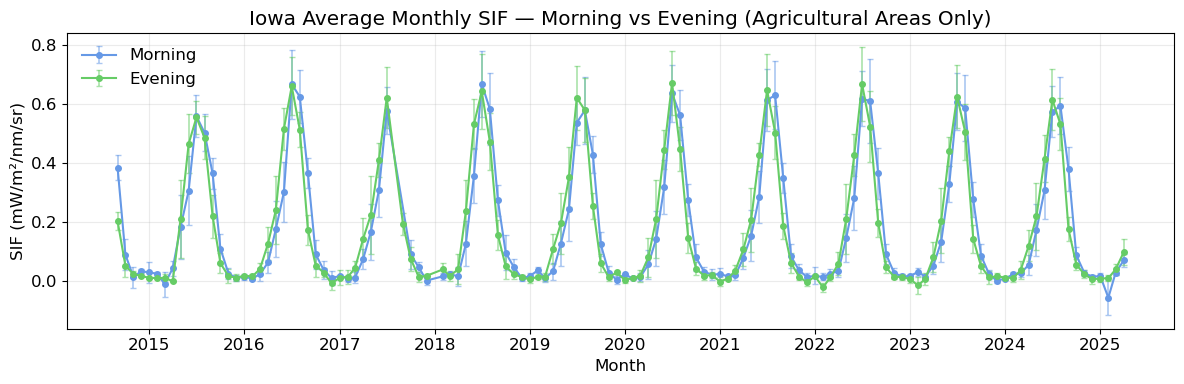

In [ ]:
# ---- Plot monthly SIF with error bars (SD) for morning (a) and evening (b) ----

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Keep only the columns we need, sort by time, and ensure types
plot_df = (
    df[["date", "ab", "sif_mean", "sif_sd"]]
      .dropna(subset=["date", "ab", "sif_mean"])        # drop any accidental empties
      .sort_values(["date", "ab"])
      .copy()
)
plot_df["date"] = pd.to_datetime(plot_df["date"])

# Split into morning ('a') and evening ('b') series
am = plot_df[plot_df["ab"] == "a"].copy()
pm = plot_df[plot_df["ab"] == "b"].copy()

# Create the figure and set up nice date formatting on the x-axis
fig, ax = plt.subplots(figsize=(12, 4))

# One major tick per calendar year, label as YYYY
ax.xaxis.set_major_locator(mdates.YearLocator(1))       # tick every 1 year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # show 2014, 2015, ...
marker_style = dict(marker="o", ms=4, mfc="white", mec="none")  # same marker for both series
err_style_a  = dict(elinewidth=1.2, ecolor=(0, 0.2, 0.8, 0.35), capsize=2)  # AM error bars, translucent
err_style_b  = dict(elinewidth=1.2, ecolor=(0.8, 0.2, 0, 0.35), capsize=2)  # PM error bars, translucent

# Darker, still soft and matched
am_color = (0.4, 0.6, 0.9)  
pm_color = (0.4, 0.8, 0.4) 


# AM: solid markers + faded error bars
ax.errorbar(
    am["date"], am["sif_mean"], yerr=am["sif_sd"],
    fmt="-o",                    # line + circle markers
    color=am_color,              # line & marker edge color
    mfc=am_color,                # <-- solid marker face color (fixes white markers)
    mec=am_color,                # marker edge same as line
    ms=4,                        # marker size
    elinewidth=1.2,
    ecolor=(am_color[0], am_color[1], am_color[2], 0.55),  # translucent error bars
    capsize=2,
    linewidth=1.5,
    label="Morning",
    zorder=3
)

# PM: solid markers + faded error bars
ax.errorbar(
    pm["date"], pm["sif_mean"], yerr=pm["sif_sd"],
    fmt="-o",
    color=pm_color,
    mfc=pm_color,                # <-- solid marker face color
    mec=pm_color,
    ms=4,
    elinewidth=1.2,
    ecolor=(pm_color[0], pm_color[1], pm_color[2], 0.55),
    capsize=2,
    linewidth=1.5,
    label="Evening",
    zorder=3
)

# Labels, legend, grid, and tight layout
ax.set_title("Iowa Average Monthly SIF — Morning vs Evening (Agricultural Areas Only)")
ax.set_xlabel("Month")
ax.set_ylabel("SIF (mW/m²/nm/sr)")
ax.legend(loc="best", frameon=False)
ax.grid(alpha=0.25)
fig.tight_layout()

# Save to file
fig.savefig("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_ab_mean_sd.png", dpi=200)

plt.show()


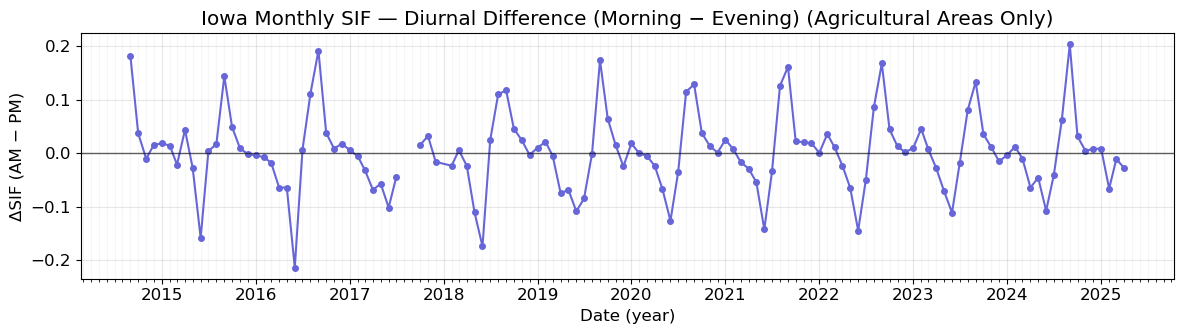

In [53]:
# ---- Diurnal difference plot: (Morning SIF) - (Evening SIF) ----

# Pivot to get columns 'a' and 'b' side-by-side, then compute delta
wide = (
    df[["date", "ab", "sif_mean"]]
      .dropna()
      .pivot(index="date", columns="ab", values="sif_mean")
      .rename(columns={"a": "sif_a", "b": "sif_b"})
      .sort_index()
)
wide["delta_a_minus_b"] = wide["sif_a"] - wide["sif_b"]

# Make the figure
fig, ax = plt.subplots(figsize=(12, 3.5))

# Line + solid markers
ax.plot(wide.index, wide["delta_a_minus_b"], "-o", linewidth=1.5, ms=4, color=(0.40, 0.40, 0.85))

# Zero reference line
ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)

# Year ticks on x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))             # one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))      # label as YYYY
ax.xaxis.set_minor_locator(mdates.MonthLocator())             # (optional) light monthly ticks

# Labels & cosmetics
ax.set_title("Iowa Monthly SIF — Diurnal Difference (Morning − Evening) (Agricultural Areas Only)")
ax.set_xlabel("Date (year)")
ax.set_ylabel("ΔSIF (AM − PM)")
ax.grid(which="major", alpha=0.3)
ax.grid(which="minor", alpha=0.1)
fig.tight_layout()
plt.show()

# Save to file
fig.savefig("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_ab_delta.png", dpi=200)


## 4. Mask Debugging and Checks

In [54]:
# Debug: Check if agricultural masking is working
print("=" * 60)
print("DEBUGGING AGRICULTURAL MASKING")
print("=" * 60)

# Let's check a few things about our data
print("1. Checking DataFrame summary:")
print(f"   Total records: {len(df)}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   SIF mean range: {df['sif_mean'].min():.4f} to {df['sif_mean'].max():.4f}")
print()

print("2. Checking resized agricultural masks:")
if 'resized_ag_masks' in locals():
    for year in sorted(resized_ag_masks.keys())[:3]:  # Check first 3 years
        if resized_ag_masks[year] is not None:
            ag_pct = 100 * np.sum(resized_ag_masks[year]) / resized_ag_masks[year].size
            print(f"   {year}: {ag_pct:.1f}% agricultural pixels (shape: {resized_ag_masks[year].shape})")
        else:
            print(f"   {year}: No resized mask available")
else:
    print("   resized_ag_masks not found - run the resizing cell first!")
print()

print("3. Let's test one SIF file with and without masking:")
if len(file_info) > 0:
    # Get a sample SIF file
    sample_info = file_info[0]
    sample_year = int(sample_info['year'])
    print(f"   Testing with {sample_info['filename']} (year {sample_year})")
    
    # Load and process the sample file
    da = open_sif_da(sample_info['file_path'])
    da_ia = clip_to_bbox_latlon(da, IOWA_BBOX)
    
    # Calculate statistics WITHOUT masking
    mu_no_mask, sd_no_mask = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, ag_mask=None)
    print(f"   WITHOUT agricultural mask: mean={mu_no_mask:.4f}, sd={sd_no_mask:.4f}")
    
    # Calculate statistics WITH resized masking
    if 'resized_ag_masks' in locals() and sample_year in resized_ag_masks and resized_ag_masks[sample_year] is not None:
        mu_with_mask, sd_with_mask = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, resized_ag_masks[sample_year])
        print(f"   WITH resized agricultural mask: mean={mu_with_mask:.4f}, sd={sd_with_mask:.4f}")
        print(f"   Difference: mean={mu_with_mask-mu_no_mask:.4f}, sd={sd_with_mask-sd_no_mask:.4f}")
        
        if abs(mu_with_mask - mu_no_mask) < 0.001:
            print("   ⚠️  WARNING: Very small difference - masking might not be working!")
        else:
            print("   ✓ Masking is working - values are different")
    else:
        print(f"   No resized agricultural mask available for year {sample_year}")

print()
print("4. Check if the issue is shape mismatch:")
if len(file_info) > 0 and 'resized_ag_masks' in locals() and sample_year in resized_ag_masks and resized_ag_masks[sample_year] is not None:
    print(f"   SIF data shape: {da_ia.shape}")
    print(f"   Resized mask shape: {resized_ag_masks[sample_year].shape}")
    if da_ia.shape == resized_ag_masks[sample_year].shape:
        print("   ✓ Shapes match - masking should work")
    else:
        print("   ❌ Shape mismatch - this is still a problem!")
else:
    print("   Cannot check shapes - resized_ag_masks not available")

print()
print("=" * 60)


DEBUGGING AGRICULTURAL MASKING
1. Checking DataFrame summary:
   Total records: 251
   Date range: 2014-09-01 00:00:00 to 2025-04-01 00:00:00
   SIF mean range: -0.0558 to 0.6701

2. Checking resized agricultural masks:
   2014: 53.6% agricultural pixels (shape: (62, 130))
   2015: 51.6% agricultural pixels (shape: (62, 130))
   2016: 51.6% agricultural pixels (shape: (62, 130))

3. Let's test one SIF file with and without masking:
   Testing with sif_ann_201409a.nc4 (year 2014)
    Raw SIF data shape: (62, 130)
    Raw SIF data - valid pixels: 7998
    Simple statistics - Mean: 0.3848, SD: 0.0457
   WITHOUT agricultural mask: mean=0.3848, sd=0.0457
    Raw SIF data shape: (62, 130)
    Raw SIF data - valid pixels: 7998
    Agricultural mask shape: (62, 130)
    Agricultural pixels in mask: 4319
    After masking - valid agricultural pixels: 4291
    Simple statistics - Mean: 0.3841, SD: 0.0434
   WITH resized agricultural mask: mean=0.3841, sd=0.0434
   Difference: mean=-0.0007, sd=-0

In [55]:
# Investigate why SIF values are similar with and without masking
print("=" * 60)
print("INVESTIGATING SIMILAR SIF VALUES")
print("=" * 60)

if len(file_info) > 0 and 2014 in resized_ag_masks:
    sample_info = file_info[0]
    da = open_sif_da(sample_info['file_path'])
    da_ia = clip_to_bbox_latlon(da, IOWA_BBOX)
    
    # Get the resized mask
    mask = resized_ag_masks[2014]
    
    print(f"1. Agricultural coverage in Iowa:")
    ag_pct = 100 * np.sum(mask) / mask.size
    print(f"   Agricultural pixels: {np.sum(mask)} / {mask.size} ({ag_pct:.1f}%)")
    print(f"   Non-agricultural pixels: {np.sum(~mask)} / {mask.size} ({100-ag_pct:.1f}%)")
    
    print(f"\n2. SIF values by land cover type:")
    sif_data = da_ia.values
    
    # Agricultural SIF values
    ag_sif = sif_data[mask & np.isfinite(sif_data)]
    non_ag_sif = sif_data[~mask & np.isfinite(sif_data)]
    
    print(f"   Agricultural SIF:")
    print(f"     Count: {len(ag_sif)} pixels")
    print(f"     Mean: {np.mean(ag_sif):.4f}")
    print(f"     Std:  {np.std(ag_sif):.4f}")
    print(f"     Range: {np.min(ag_sif):.4f} to {np.max(ag_sif):.4f}")
    
    print(f"   Non-agricultural SIF:")
    print(f"     Count: {len(non_ag_sif)} pixels")
    print(f"     Mean: {np.mean(non_ag_sif):.4f}")
    print(f"     Std:  {np.std(non_ag_sif):.4f}")
    print(f"     Range: {np.min(non_ag_sif):.4f} to {np.max(non_ag_sif):.4f}")
    
    print(f"\n3. Difference analysis:")
    mean_diff = np.mean(ag_sif) - np.mean(non_ag_sif)
    print(f"   Mean difference (Ag - Non-Ag): {mean_diff:.4f}")
    print(f"   Relative difference: {100 * mean_diff / np.mean(ag_sif):.2f}%")
    
    if abs(mean_diff) < 0.01:
        print(f"   → Very small difference - this explains why masking has little effect")
    elif abs(mean_diff) < 0.05:
        print(f"   → Small difference - masking will have some effect")
    else:
        print(f"   → Significant difference - masking should have noticeable effect")
    
    print(f"\n4. Overall statistics:")
    all_sif = sif_data[np.isfinite(sif_data)]
    print(f"   All pixels mean: {np.mean(all_sif):.4f}")
    print(f"   Agricultural mean: {np.mean(ag_sif):.4f}")
    print(f"   Difference: {np.mean(ag_sif) - np.mean(all_sif):.4f}")
    
    # Check if the issue is that Iowa is mostly agricultural
    if ag_pct > 80:
        print(f"\n5. Conclusion:")
        print(f"   Iowa is {ag_pct:.1f}% agricultural - this explains why masking has little effect!")
        print(f"   The non-agricultural areas are too small to significantly change the average.")
    else:
        print(f"\n5. Conclusion:")
        print(f"   Iowa is {ag_pct:.1f}% agricultural - masking should have some effect.")
        print(f"   The small difference ({mean_diff:.4f}) suggests similar SIF values across land cover types.")

else:
    print("No data available for investigation")


INVESTIGATING SIMILAR SIF VALUES
1. Agricultural coverage in Iowa:
   Agricultural pixels: 4319 / 8060 (53.6%)
   Non-agricultural pixels: 3741 / 8060 (46.4%)

2. SIF values by land cover type:
   Agricultural SIF:
     Count: 4291 pixels
     Mean: 0.3841
     Std:  0.0434
     Range: 0.1714 to 0.5307
   Non-agricultural SIF:
     Count: 3707 pixels
     Mean: 0.3856
     Std:  0.0482
     Range: 0.1133 to 0.5817

3. Difference analysis:
   Mean difference (Ag - Non-Ag): -0.0014
   Relative difference: -0.37%
   → Very small difference - this explains why masking has little effect

4. Overall statistics:
   All pixels mean: 0.3848
   Agricultural mean: 0.3841
   Difference: -0.0007

5. Conclusion:
   Iowa is 53.6% agricultural - masking should have some effect.
   The small difference (-0.0014) suggests similar SIF values across land cover types.


## 5. Seasonal Averages Across All Years

In [ ]:
# Step 1: Calculate monthly averages across all years
print("=" * 60)
print("STEP 1: CALCULATING MONTHLY AVERAGES")
print("=" * 60)

# Calculate average SIF for each month across all years
# We'll create three different averages:

print("1. Morning (AM) averages by month:")
morning_data = df[df['ab'] == 'a']  # Filter for morning data
morning_monthly = morning_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(morning_monthly)
print()

print("2. Evening (PM) averages by month:")
evening_data = df[df['ab'] == 'b']  # Filter for evening data
evening_monthly = evening_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(evening_monthly)
print()

print("3. Combined (AM + PM) averages by month:")
# For combined, we'll average the morning and evening values for each month
combined_monthly = df.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(combined_monthly)
print()

print("Summary:")
print(f"- Morning data: {len(morning_data)} records")
print(f"- Evening data: {len(evening_data)} records") 
print(f"- Total data: {len(df)} records")
print(f"- Months covered: {sorted(df['month'].unique())}")
print()

print("✓ Monthly averages calculated successfully!")
print("Next step: We'll create the seasonal cycle plot with these three lines.")


STEP 2: CALCULATING MONTHLY AVERAGES
1. Morning (AM) averages by month:
           mean       std  count
month                           
1      0.018635  0.005730     10
2      0.012223  0.024371     11
3      0.017078  0.011078     11
4      0.052710  0.019030     11
5      0.153042  0.021083     10
6      0.303621  0.030049     10
7      0.604675  0.043950     10
8      0.584677  0.037930      9
9      0.346143  0.053294     10
10     0.093942  0.013009     11
11     0.031613  0.009972     11
12     0.012893  0.009266     11

2. Evening (PM) averages by month:
           mean       std  count
month                           
1      0.009641  0.005784     10
2      0.009093  0.015952     11
3      0.025595  0.013713     11
4      0.087639  0.041744     11
5      0.216074  0.014191     10
6      0.442502  0.051801     10
7      0.631585  0.034048     10
8      0.505923  0.037641      9
9      0.186462  0.033012     11
10     0.055459  0.008935     11
11     0.018750  0.005330     11
1

STEP 3: CREATING SEASONAL CYCLE PLOT
Preparing data for plotting...
Months with data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Morning means: [0.0186353  0.01222268 0.01707803 0.05271034 0.15304182 0.30362059
 0.60467456 0.58467731 0.34614261 0.09394177 0.03161326 0.01289332]
Evening means: [0.00964109 0.00909294 0.02559518 0.08763853 0.21607355 0.44250152
 0.63158541 0.5059225  0.18646213 0.05545916 0.01875017 0.01250079]
Combined means: [0.0141382  0.01065781 0.0213366  0.07017443 0.18455769 0.37306105
 0.61812998 0.54529991 0.26250045 0.07470046 0.02518172 0.01269705]

Creating the plot with your requested changes...
✓ Plot saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png


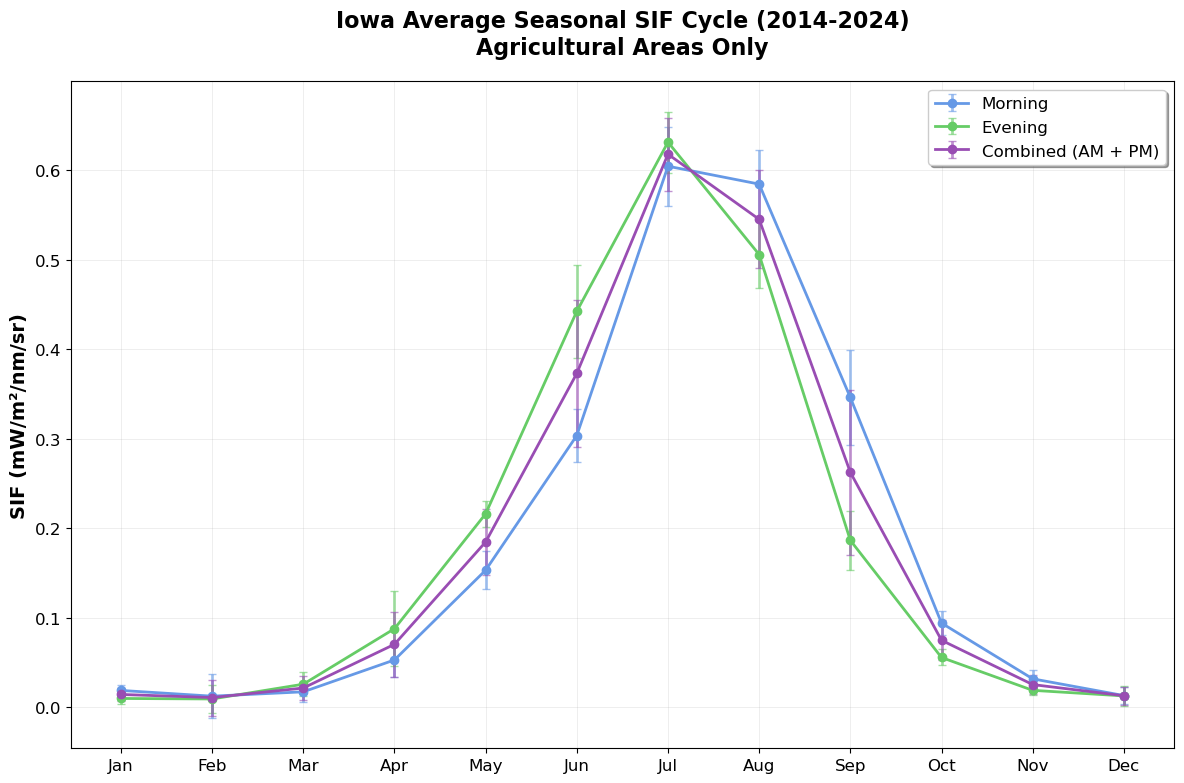

✓ Seasonal cycle plot complete!
This shows the typical seasonal pattern of SIF in Iowa agricultural areas.
Changes made:
- All markers are circles (same shape)
- Error bars are 60% opacity (semi-transparent)
- Proper titles and axis labels added


In [ ]:
# Step 2: Create the seasonal cycle plot
print("=" * 60)
print("STEP 2: CREATING SEASONAL CYCLE PLOT")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np

# Step 2a: Prepare the data for plotting
print("Preparing data for plotting...")

# Create month names for better x-axis labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Get the month numbers that we have data for
months_with_data = sorted(morning_monthly.index)
print(f"Months with data: {months_with_data}")

# Extract the mean values for each line
morning_means = morning_monthly['mean'].values
evening_means = evening_monthly['mean'].values
combined_means = combined_monthly['mean'].values

# Extract standard deviations for error bars
morning_stds = morning_monthly['std'].values
evening_stds = evening_monthly['std'].values
combined_stds = combined_monthly['std'].values

print(f"Morning means: {morning_means}")
print(f"Evening means: {evening_means}")
print(f"Combined means: {combined_means}")
print()

# Step 2b: Create the plot with your requested changes
print("Creating the plot with your requested changes...")

# Define colors (using your existing color scheme)
am_color = (0.4, 0.6, 0.9)  # Medium light blue
pm_color = (0.4, 0.8, 0.4)  # Medium light green
combined_color = (0.6, 0.3, 0.7)  # Purple for combined

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three lines with error bars using your colors
# All lines use circles for markers since colors are different
# Morning line (blue)
ax.errorbar(months_with_data, morning_means, yerr=morning_stds,
            fmt='-o', color=am_color, linewidth=2, markersize=6,
            label='Morning', capsize=3, capthick=1, 
            mfc=am_color, mec=am_color,  # Solid markers
            ecolor=(am_color[0], am_color[1], am_color[2], 0.6))  # Semi-transparent error bars only

# Evening line (green) 
ax.errorbar(months_with_data, evening_means, yerr=evening_stds,
            fmt='-o', color=pm_color, linewidth=2, markersize=6,
            label='Evening', capsize=3, capthick=1, 
            mfc=pm_color, mec=pm_color,  # Solid markers
            ecolor=(pm_color[0], pm_color[1], pm_color[2], 0.6))  # Semi-transparent error bars only

# Combined line (purple)
ax.errorbar(months_with_data, combined_means, yerr=combined_stds,
            fmt='-o', color=combined_color, linewidth=2, markersize=6,
            label='Combined (AM + PM)', capsize=3, capthick=1, 
            mfc=combined_color, mec=combined_color,  # Solid markers
            ecolor=(combined_color[0], combined_color[1], combined_color[2], 0.6))  # Semi-transparent error bars only

# Add proper labels and formatting
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_ylabel('SIF (mW/m²/nm/sr)', fontsize=14, fontweight='bold')
ax.set_title('Iowa Average Seasonal SIF Cycle (2014-2024)\nAgricultural Areas Only', 
             fontsize=16, fontweight='bold', pad=20)

# Set x-axis to show month names
ax.set_xticks(months_with_data)
ax.set_xticklabels([month_names[m-1] for m in months_with_data], fontsize=12)

# Add legend and grid
ax.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Make it look nice
plt.tight_layout()

# Save the figure
output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png"
fig.savefig(output_path, dpi=200, bbox_inches='tight')
print(f"✓ Plot saved to: {output_path}")

# Show the plot
plt.show()

print("✓ Seasonal cycle plot complete!")
print("This shows the typical seasonal pattern of SIF in Iowa agricultural areas.")
print("Changes made:")
print("- All markers are circles (same shape)")
print("- Error bars are 60% opacity (semi-transparent)")
print("- Proper titles and axis labels added")


## 6. Drought Year Anomalies